# MEG timing correction

### digital timing signal

first, let's read in a file

In [1]:
from dfply import *
from pathlib import Path

data_dir = Path('/data/hnl/opm-meg')
hdf_file = data_dir / 'dat' / 'sessions' / 'OPM0002' / 'QZFM_1.h5'

# read in raw TTL signal, in this case on channels 75-78
dfs = []
for ch in [75, 76, 77, 78]:
    dfs.append(
        pd.read_hdf(str(hdf_file), key = f'data/ch{ch:03d}') >>
        rename(voltage=X.Y_Value) >>
        select(X.time, X.voltage)
    )

# combine channels into one signal
ttl_raw = (pd.concat(dfs) >> arrange(X.time))

ttl_raw >> head(3)

,time,voltage
87300000,0.000042,0.005562
88464000,0.000056,0.000468
89628000,0.000070,-0.000518


next, we'll analyze the signal

In [2]:
# hive modules are not on the default python path
import sys
sys.path.append('/data/git/iterate-config.git/src/main/python/')

from hive.signal import ttl

ttl_up, ttl_dn, ttl_threshold = ttl.find_edges(ttl_raw)

now, we have rising and falling edges!

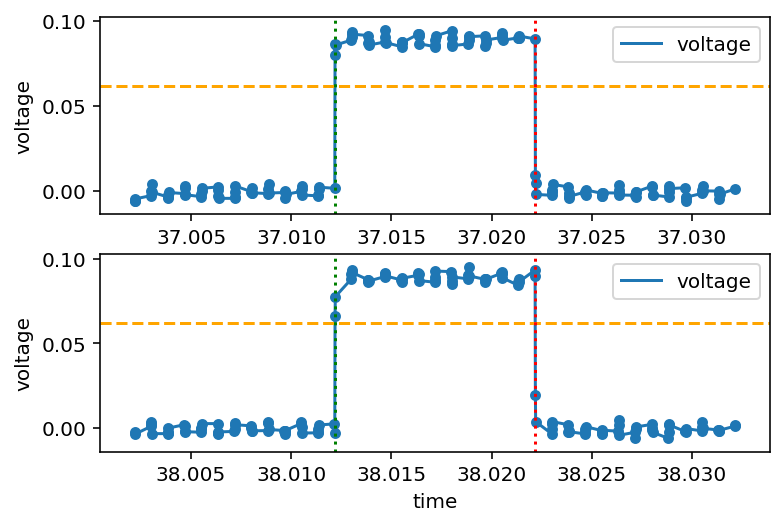

In [31]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=1)

ttl_upq = ttl_up >> mask(X.dt < 0.0001)

for n in [0, 1]:
    ttl_dnq = (
        ttl_dn >> 
        mask(X.onset > ttl_upq.onset.iloc[n], 
             X.onset < ttl_upq.onset.iloc[n] + 0.5)
    )
    
    ttl_plot = (
        ttl_raw >>
        mask(X.time > ttl_upq.onset.iloc[n] - 0.01, 
             X.time < ttl_dnq.onset.iloc[0] + 0.01)
    )

    
    ttl_plot.plot(x='time', y='voltage', kind='line', ax=ax[n])
    ttl_plot.plot(x='time', y='voltage', kind='scatter', ax=ax[n])
    
    ax[n].autoscale(axis = 'both', tight = False)
    
    ax[n].axhline(y=ttl_threshold, linestyle='--', color='orange')
    ax[n].axvline(x=ttl_upq.onset.iloc[n], linestyle=':', color='green')
    ax[n].axvline(x=ttl_dnq.onset.iloc[0], linestyle=':', color='red')
    
    

let's analyze the signal...

In [4]:
d = ttl_up.interval
print(
    f'''n........{d.count()}
min......{d.min(skipna=True):.9f}
mode.....{d.mode().max():.9f}
median...{d.median(skipna=True):.9f}
mean.....{d.mean(skipna=True):.9f}
max......{d.max(skipna=True):.9f}''')

n........964
min......0.999989500
mode.....0.999990000
median...0.999990000
mean.....1.000004695
max......1.000406500


now, let's create a slightly dirty event timeline from the TTL rising edges

In [5]:
import hive.timing.periodic as per

times = ttl_up.onset

# drop a few events
times = times.drop([3, 22, 72])

# add a few extra events
times = times.append(pd.Series([16.58, 16.60, 16.62, 16.63]))

# sort it out
times = times.sort_values()
times = times.reset_index(drop=True)

ttl0 = per.PeriodicSignal(times)
print(f'ADC0:\n{ttl0}')

ADC0:
    start:    3.012116500
    end:    967.016642500
    ePer:     0.999990000
    mPer:     0.999553872
    count:  965
    hits:   962
    skips:    3
    extra:    4


...and now, let's regularize it using the estimated period found above

In [6]:
ttl1 = ttl0.regularize(ttl0.estimated_period, .01)

print(f'ADC1:\n{ttl1}')

ADC1:
    start:    3.012116500
    end:    967.016642500
    ePer:     0.999990000
    mPer:     1.000004695
    count:  965
    hits:   965
    skips:    0
    extra:    0


In [7]:
df = pd.DataFrame(data={
    'ttl0' : ttl0.onset_times, 
    'd0'   : ttl0.onset_times.diff(), 
    'ttl1' : ttl1.onset_times, 
    'd1'   : ttl1.onset_times.diff()
})

df.head(20)

,ttl0,d0,ttl1,d1
0,3.012117,NaN,3.012117,NaN
1,4.012106,0.999990,4.012106,0.99999
2,5.012097,0.999990,5.012097,0.99999
3,7.012077,1.999980,6.012087,0.99999
4,8.012066,0.999990,7.012077,0.99999
5,9.012056,0.999990,8.012066,0.99999
6,10.012047,0.999990,9.012056,0.99999
7,11.012037,0.999990,10.012047,0.99999
8,12.012027,0.999990,11.012037,0.99999
9,13.012016,0.999990,12.012027,0.99999


### behavioral timing events

now, let's do the same thing with behavioral data...

In [8]:
beh_file = data_dir / 'dat' / 'behavior' / '599-EAAG.txt'

beh_trs = (
    pd.read_table(beh_file, sep='\t', header=None, names=['timestamp', 'event']) >> 
    mask(X.timestamp > 0) >>
    arrange(X.timestamp) >>
    mutate(time=(X.timestamp - first(X.timestamp)) / 1e3) >>
    mask(X.event.str.contains('^TR')) >>
    mutate(onset=X.time - first(X.time)) >>
    mutate(interval=X.onset.diff())
).reset_index(drop=True)

( beh_trs >> head(10) )

,timestamp,event,time,onset,interval
0,1525863760496,TR 1,1239.898,0.000,NaN
1,1525863761455,TR 2,1240.857,0.959,0.959
2,1525863762455,TR 3,1241.857,1.959,1.000
3,1525863763455,TR 4,1242.857,2.959,1.000
4,1525863764455,TR 5,1243.857,3.959,1.000
5,1525863765455,TR 6,1244.857,4.959,1.000
6,1525863766455,TR 7,1245.857,5.959,1.000
7,1525863767454,TR 8,1246.856,6.958,0.999
8,1525863768454,TR 9,1247.856,7.958,1.000
9,1525863769454,TR 10,1248.856,8.958,1.000


In [9]:
ttl_trs = pd.DataFrame(data={
    'time'     : ttl1.onset_times,
    'onset'    : ttl1.onset_times - ttl1.onset_times.iloc[0],
    'interval' : ttl1.onset_times.diff()
})

ttl_trs >> head(10)

,time,onset,interval
0,3.012117,0.00000,NaN
1,4.012106,0.99999,0.99999
2,5.012097,1.99998,0.99999
3,6.012087,2.99997,0.99999
4,7.012077,3.99996,0.99999
5,8.012066,4.99995,0.99999
6,9.012056,5.99994,0.99999
7,10.012047,6.99993,0.99999
8,11.012037,7.99992,0.99999
9,12.012027,8.99991,0.99999


In [10]:
ttl1.hit_count

965

In [11]:
beh_trs.shape

(3726, 5)